In [1]:
import os
import sys
ROOT = os.getenv('BONNER_ROOT_PATH')
sys.path.append(ROOT)
from image_tools.loading import load_image_paths, get_image_labels
from config import CACHE, NSD_SAMPLE_IMAGES
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import torch
import numpy as np
from model_evaluation.predicting_brain_data.benchmarks.majajhong import load_majaj_data
from model_evaluation.predicting_brain_data.benchmarks.nsd import load_nsd_data
from model_evaluation.predicting_brain_data.benchmarks.nsd import filter_activations
from model_features.models.models import load_iden
from tqdm import tqdm

import pickle
from config import CACHE, NSD_NEURAL_DATA      
SHARED_IDS_PATH = os.path.join(ROOT, 'image_tools','nsd_ids_shared')
SHARED_IDS = pickle.load(open(SHARED_IDS_PATH, 'rb'))
SHARED_IDS = [image_id.strip('.png') for image_id in SHARED_IDS]
PREDS_PATH = '/data/atlas/.cache/beta_predictions'

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

def compute_similarity_matrix(features):
    """
    Compute the similarity matrix (using Pearson correlation) for a set of features.
    """
    # Compute the pairwise distances (using correlation) and convert to similarity
    return 1 - squareform(pdist(features, 'correlation'))

def rsa(features1, features2):
    """
    Perform Representational Similarity Analysis between two sets of features.
    """
    # Compute similarity matrices for both sets of features
    sim_matrix_1 = compute_similarity_matrix(features1)
    sim_matrix_2 = compute_similarity_matrix(features2)

    # Flatten the upper triangular part of the matrices
    upper_tri_indices = np.triu_indices_from(sim_matrix_1, k=1)
    sim_matrix_1_flat = sim_matrix_1[upper_tri_indices]
    sim_matrix_2_flat = sim_matrix_2[upper_tri_indices]

    # Compute the Spearman correlation between the flattened matrices
    correlation, p_value = spearmanr(sim_matrix_1_flat, sim_matrix_2_flat)

    return correlation, p_value

# Example usage
# features1 and features2 should be numpy arrays of shape (n_images, n_features)
# features1 = ...
# features2 = ...

# correlation, p_value = rsa(features1, features2)
# print("RSA Correlation:", correlation)
# print("P-value:", p_value)


In [ ]:
# features1 = torch.Tensor(xr.open_dataset('/data/atlas/.cache/activations/expansion_features=3000_layers=5_dataset=naturalscenes').x.values).cuda()
# features2 =  torch.Tensor(xr.open_dataset('/data/atlas/.cache/activations/alexnet_conv5_layers=5_features=256_gpool=False_dataset=naturalscenes').x.values).cuda()
# rsa(features1, features2)

In [ ]:
# import os

# # Replace 'old_filename.ext' with the current file name
# # and 'new_filename.ext' with the new file name you want.
# p = '/data/atlas/.cache/beta_predictions'

# dataset = 'majajhong'
# # dataset = 'naturalscenes'
# layers = 5
# features = 3

# regions = ['V4','IT']
# # regions = ['early visual stream','midventral visual stream','ventral visual stream']
# for region in regions:
    
#     for i in ['Tito','Chabo']:
    
#         new_name = f'expansion_features={features}_layers={layers}_dataset={dataset}_{region}_{i}.pkl'
#         old_name = f'expansion_{features}_dataset={dataset}_{region}_{i}.pkl'
#         # Renaming the file
#         os.rename(os.path.join(p,old_name), os.path.join(p,new_name))
    

In [ ]:
import torch
import torch.nn.functional as F

def z_score(tensor, dim):
    """
    Apply z-score standardization to the given tensor along the specified dimension.
    """
    mean = tensor.mean(dim=dim, keepdim=True)
    std = tensor.std(dim=dim, keepdim=True)
    return (tensor - mean) / (std)

def pearson_r_modified(x, y, nan_policy='omit'):
    """
    Compute Pearson correlation coefficients for batches of bootstrap samples with z-scoring and NaN handling.

    Parameters:
    x (torch.Tensor): A 3D tensor of shape (n_bootstraps, n_samples, n_features).
    y (torch.Tensor): A 3D tensor of shape (n_bootstraps, n_samples, n_features).
    nan_policy (str): Policy for handling NaNs, 'omit' to ignore NaNs in calculations.

    Returns:
    torch.Tensor: 1D tensor of Pearson correlation coefficients for each bootstrap.
    """
    if x.shape != y.shape:
        raise ValueError("Input tensors must have the same shape")

    # Handling NaN values
    if nan_policy == 'omit':
        mask = torch.isnan(x) | torch.isnan(y)
        x = torch.where(mask, torch.tensor(0.0, device=x.device), x)
        y = torch.where(mask, torch.tensor(0.0, device=y.device), y)

    # Z-scoring (standardizing) the data
    x = z_score(x, dim=2)
    y = z_score(y, dim=2)

    # Calculating Pearson Correlation Coefficient
    sum_sq_x = torch.sum(x ** 2, axis=2)
    sum_sq_y = torch.sum(y ** 2, axis=2)
    sum_coproduct = torch.sum(x * y, axis=2)
    denominator = torch.sqrt(sum_sq_x * sum_sq_y)

    # Avoid division by zero
    denominator = torch.where(denominator != 0, denominator, torch.ones_like(denominator))

    r_values = sum_coproduct / denominator

    # Average across the samples in each bootstrap
    mean_r_values = torch.mean(r_values, axis=1)

    return mean_r_values


In [2]:
import torch

def pearson_r_(x, y):
    """
    Compute Pearson correlation coefficients for batches of bootstrap samples.

    Parameters:
    x (torch.Tensor): A 3D tensor of shape (n_bootstraps, n_samples, n_features).
    y (torch.Tensor): A 3D tensor of shape (n_bootstraps, n_samples, n_features).

    Returns:
    torch.Tensor: 1D tensor of Pearson correlation coefficients for each bootstrap.
    """
    # Ensure the input tensors are of the same shape
    if x.shape != y.shape:
        raise ValueError("Input tensors must have the same shape")

    # Mean-centering the data
    x_mean = torch.mean(x, dim=2, keepdim=True)
    y_mean = torch.mean(y, dim=2, keepdim=True)
    x = x - x_mean
    y = y - y_mean

    # Calculating Pearson Correlation Coefficient
    sum_sq_x = torch.sum(x ** 2, axis=2)
    sum_sq_y = torch.sum(y ** 2, axis=2)
    sum_coproduct = torch.sum(x * y, axis=2)
    denominator = torch.sqrt(sum_sq_x * sum_sq_y)

    # Avoid division by zero
    denominator = torch.where(denominator != 0, denominator, torch.ones_like(denominator))

    r_values = sum_coproduct / denominator

    # Average across the samples in each bootstrap
    mean_r_values = torch.mean(r_values, axis=1)

    return mean_r_values


In [3]:
def make_pandas_df(identifier, subjects, features=None, names=None):
    
    df = pd.DataFrame()
    index = 0        
    
    data = xr.open_dataset(os.path.join(CACHE,'encoding_scores_torch',identifier), engine='h5netcdf')

    for subject in subjects:
        subject_data = data.where(data.subject == subject, drop=True)
        mean_r = subject_data.r_value.values.mean()

        df_tmp =  pd.DataFrame({'score':mean_r,
                                'iden':identifier,
                                'subject':subject},index=[index])
        if features is not None:
            df_tmp['features'] = str(features)
        
        if names is not None:
            df_tmp['names'] = names
            
        df = pd.concat([df,df_tmp])
        index+=1

    return df

In [4]:
def make_pandas_df_30k(identifier, subjects, region, features=None, names=None):
    
    df = pd.DataFrame()
    index = 0        
    
    for subject in subjects:
        
        subject_data = xr.open_dataset(f'/data/atlas/.cache/encoding_scores_torch/expansion_30000_dataset=naturalscenes_subject={subject}_{region}', 
                                  engine='netcdf4')
        mean_r = subject_data.r_value.values.mean()

        df_tmp =  pd.DataFrame({'score':mean_r,
                                'iden':identifier,
                                'subject':subject},index=[index])
        if features is not None:
            df_tmp['features'] = str(features*36)
        
        if names is not None:
            df_tmp['names'] = names
            
        df = pd.concat([df,df_tmp])
        index+=1

    return df

In [5]:
#xr.open_dataset('/data/atlas/.cache/activations/expansion_30000_dataset=naturalscenes_subject=1').x.values[:5]

# Bootstrap

engineered mdoels

In [31]:
import pickle
from model_evaluation.predicting_brain_data.benchmarks.nsd import load_nsd_data
from model_evaluation.predicting_brain_data.benchmarks.majajhong import load_majaj_data
from model_evaluation.predicting_brain_data.regression.regression import pearson_r
from tqdm import tqdm
import numpy as np

In [32]:
def get_bootstrap_data(models, num_features, layers, dataset, region, all_sampled_indices, file_name, batch_size=50, n_bootstraps=1000):


    if 'naturalscenes' in dataset:
        SUBJECTS = [i for i in range(8)]
    elif 'majajhong' in dataset:
        SUBJECTS = ['Chabo','Tito']
    else:
        print('unknown dataset')
    
    
    data_dict = {'model':[],'features':[],'score':[], 'lower':[],'upper':[]}
    mean_scores = []
    lower_bound = []
    upper_bound = []              
        
    
    for features in num_features:

        print(features)

        for model_name in models:

                print(model_name)

                activations_identifier = load_iden(model_name=model_name, features=features, layers=layers, dataset=dataset)
                print(activations_identifier)

                score_sum = np.zeros(n_bootstraps)
                #bootstrap_dist = []

                for subject in tqdm(SUBJECTS):

                        # load preds and y_true
                        r_values = []
                        with open(os.path.join(PREDS_PATH,f'{activations_identifier}_{region}_{subject}.pkl'), 'rb') as file:
                            preds = torch.Tensor(pickle.load(file))

                        if dataset == 'naturalscenes':
                            ids_test, neural_data_test, var_name_test = load_nsd_data(mode ='shared', subject = subject, region = region)           
                            test = torch.Tensor(neural_data_test[var_name_test].values)

                        else:
                            test = load_majaj_data(subject, region, 'test')
                            
                        
                        # Vectorized bootstrapping
                        all_sampled_preds = preds[all_sampled_indices]
                        all_sampled_tests = test[all_sampled_indices]

                        i = 0
                        batch = batch_size
                        while i < n_bootstraps:
                            # Compute Pearson r for all bootstraps at once
                            mean_r_values = pearson_r_(all_sampled_tests[i:i+batch,:,:].cuda(), 
                                                       all_sampled_preds[i:i+batch,:,:].cuda())
                            r_values.extend(mean_r_values.tolist())
                            i += batch

                        score_sum += r_values

                bootstrap_dist = score_sum/len(SUBJECTS)

                data_dict['model'].append(model_name)
                #data_dict['subject'].append(subject)
                data_dict['features'].append(str(features))
                data_dict['score'].append(np.mean(bootstrap_dist))
                data_dict['lower'].append(np.percentile(bootstrap_dist, 2.5))
                data_dict['upper'].append(np.percentile(bootstrap_dist, 97.5))


    df = pd.DataFrame.from_dict(data_dict)
    
    with open(f'bootstrap-results-{file_name}-{dataset}-{region}-df.pkl', 'wb') as file:
        pickle.dump(df,file)
        
    return df

In [33]:
DATASET = 'naturalscenes'
REGIONS = ['ventral visual stream'] #'midventral visual stream',

# DATASET = 'majajhong'
# REGIONS = ['V4']


n_bootstraps = 1000  
n_rows = 872 if DATASET=='naturalscenes' else 640
all_sampled_indices = np.random.choice(n_rows, (n_bootstraps, n_rows), replace=True) # Sample indices for all bootstraps at once


for region in REGIONS:
    
    
    df_engineered = get_bootstrap_data(models= ['expansion','expansion_linear','fully_connected'],
                            num_features=[3,30,300,3000],
                            dataset=DATASET, 
                            layers = 5,
                            file_name = 'engineered',
                            region=region,
                            n_bootstraps = n_bootstraps,
                            all_sampled_indices=all_sampled_indices)
    
    # df_ViT = get_bootstrap_data(models= ['ViT_wavelet'],
    #                         num_features=[1*12, 5*12, 50*12],
    #                         dataset=DATASET, 
    #                         layers = 5,
    #                         file_name = 'ViT',
    #                         region=region,
    #                         n_bootstraps = n_bootstraps,
    #                         all_sampled_indices=all_sampled_indices)
    
    # df_alexnet = get_bootstrap_data(models=['alexnet'],
    #                                 num_features=[None],
    #                                 dataset=DATASET, 
    #                                 layers='best',
    #                                 n_bootstraps = n_bootstraps,
    #                                 region=region,
    #                                 all_sampled_indices=all_sampled_indices)

3
expansion
expansion_features=3_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


expansion_linear
expansion_linear_features=3_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_connected
fully_connected_features=108_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.94s/it]


30
expansion
expansion_features=30_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.94s/it]


expansion_linear
expansion_linear_features=30_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.95s/it]


fully_connected
fully_connected_features=1080_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


300
expansion
expansion_features=300_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


expansion_linear
expansion_linear_features=300_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


fully_connected
fully_connected_features=10800_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.94s/it]


3000
expansion
expansion_features=3000_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


expansion_linear
expansion_linear_features=3000_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


fully_connected
fully_connected_features=108000_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


In [12]:
# new_data = pd.concat([pd.DataFrame.from_dict(old_data),df_engineered]).reset_index(drop=True)
# with open(f'bootstrap-results-engineered-{DATASET}-{region}_df.pkl', 'wb') as file:
#     pickle.dump(new_data,file)

In [13]:
# activations_identifier = load_iden(model_name='ViT_base', features=None, layers='best', dataset=DATASET)
# r_values = []
# for subject in ['Tito','Chabo']:

#         # load preds and y_true
#         with open(os.path.join(PREDS_PATH,f'{activations_identifier}_{region}_{subject}.pkl'), 'rb') as file:
#             preds = torch.Tensor(pickle.load(file))

#         # ids_test, neural_data_test, var_name_test = load_nsd_data(mode ='shared', subject = subject, region = region)           
#         # test = torch.Tensor(neural_data_test[var_name_test].values)
#         test = load_majaj_data(subject= subject, region= region, mode = 'test')

#         r_values.append(pearson_r_(test.unsqueeze(dim=0).cuda(),preds.unsqueeze(dim=0).cuda()))

# ViT_base = (sum(r_values)/len(r_values))[0].cpu()

In [52]:
DATASET = 'majajhong'
region = 'V4'

In [53]:
# activations_identifier = load_iden(model_name='fully_random_1000', features=3000, layers=5, dataset=DATASET)
# activations_identifier = activations_identifier + '_stride=1'
# r_values = []
# for subject in ['Tito','Chabo']:

#         # load preds and y_true
#         with open(os.path.join(PREDS_PATH,f'{activations_identifier}_{region}_{subject}.pkl'), 'rb') as file:
#             preds = torch.Tensor(pickle.load(file))

#         # ids_test, neural_data_test, var_name_test = load_nsd_data(mode ='shared', subject = subject, region = region)           
#         # test = torch.Tensor(neural_data_test[var_name_test].values)
#         test = load_majaj_data(subject= subject, region= region, mode = 'test')

#         r_values.append(pearson_r_(test.unsqueeze(dim=0).cuda(),preds.unsqueeze(dim=0).cuda()))

# fully_random_1000 = (sum(r_values)/len(r_values))[0].cpu()

# Main Results

In [205]:
DATASET = 'naturalscenes'
region = 'ventral visual stream'

# DATASET = 'majajhong'
# region = 'IT'

In [66]:
path = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data'

with open(os.path.join(path,f'bootstrap-results-ViT-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_ViT = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [67]:
# df = new_data.copy()
df_engineered['features'] = df_engineered['features'].apply(lambda x: int(x)*36)
df_ViT['features'] = df_ViT['features'].apply(lambda x: int(x)*196)

In [68]:
df = pd.concat([df_engineered,df_ViT]).reset_index(drop=True)

In [69]:
# df = new_data.copy()

names ={'expansion':'Convolution','ViT_Wavelet':'Transformer','fully_connected':'Fully connected'}
df['model'] = df['model'].map(names)

palette ={'Convolution':'seagreen','Transformer':'plum','Fully connected':'slateblue'}
df['color'] = df['model'].map(palette)
df = df.dropna().reset_index()

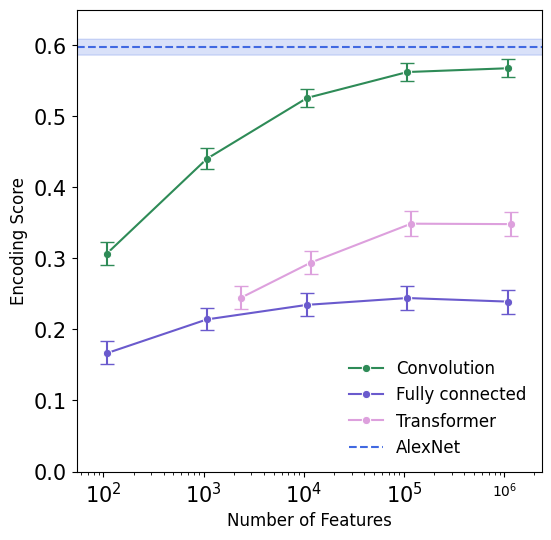

In [70]:
# main results
rcParams['figure.figsize'] = (6,6)  

ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)
# main results
rcParams['figure.figsize'] = (6,6)  

# Adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])
    
# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='royalblue', linestyle='--', label='AlexNet')
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='royalblue', alpha=0.2)

plt.xlabel('Number of Features',size=12)
plt.ylabel('Encoding Score',size=12)
plt.ylim(0,0.65)
plt.xlim(df['features'].min()/2,df['features'].max()*2)

plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
    
#plt.legend()
ax1.legend(frameon=False,fontsize=12)
#ax1.legend_.remove()

plt.savefig(f'main_results_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Effect of regression

In [51]:
DATASET = 'naturalscenes'
region = 'ventral visual stream'

# DATASET = 'majajhong'
# region = 'IT'

In [52]:
path = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data'
#load data
with open(os.path.join(path,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [53]:
df_engineered['features'] = df_engineered['features'].apply(lambda x: int(x)*36)

names ={'expansion':'Convolution','expansion_linear':'Convolution Linear',}
df_engineered['model'] = df_engineered['model'].map(names)

palette ={'Convolution':'seagreen','Convolution Linear':'orange'}
df_engineered['color'] = df_engineered['model'].map(palette)
df_engineered = df_engineered.dropna().reset_index()

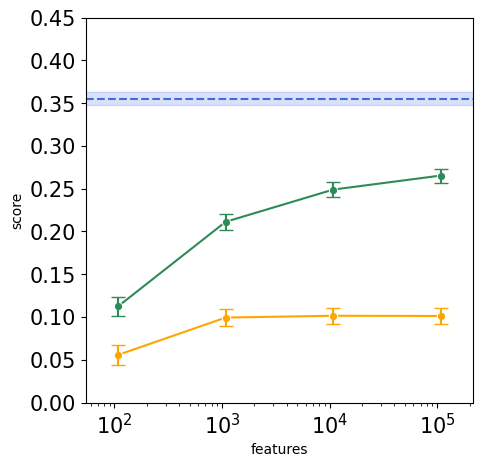

In [56]:
# main results
rcParams['figure.figsize'] = (5,5)  

ax1 = sns.lineplot(data = df_engineered, x='features', y='score', hue='model', marker='o',palette = palette)
#sns.lineplot(data = df_engineered, x='features', y='score', hue='model', marker='o',stypalette = palette)

# Adding error bars for the 95% confidence interval
for i in range(len(df_engineered)):
    plt.errorbar(df_engineered['features'][i], df_engineered['score'][i], 
                 yerr=[[df_engineered['score'][i] - df_engineered['lower'][i]], 
                       [df_engineered['upper'][i] - df_engineered['score'][i]]], 
                 fmt='none', capsize=5, color=df_engineered['color'][i])
    
# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='royalblue', linestyle='--', label='AlexNet')
plt.fill_between(np.arange(df_engineered['features'].min()/3,df_engineered['features'].max()*3), 
                 df_alexnet['lower'], 
                 df_alexnet['upper'], 
                 color='royalblue', alpha=0.2)

#plt.axhline(y=untrained_alexnet, color='grey', linestyle='--', label='Untrained AlexNet')

# plt.xlabel('Number of Features',size=20)
# plt.ylabel('Encoding Score',size=20)
plt.ylim(0,0.45)
plt.xlim(df_engineered['features'].min()/2,df_engineered['features'].max()*2)

plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
    
plt.legend(frameon=False,fontsize=12)
#ax1.legend(fontsize=10,loc='upper left')
ax1.legend_.remove()

plt.savefig(f'effects_of_regression_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Random Model

In [6]:
def get_random_model_bootstrap_data(model_name, features, filters, layers, dataset, region, all_sampled_indices, file_name, batch_size=50, n_bootstraps=1000):


    if dataset == 'naturalscenes':
        SUBJECTS = [i for i in range(8)]
    elif dataset == 'majajhong':
        SUBJECTS = ['Chabo','Tito']
    else:
        print('unknown dataset')
    
    
    data_dict = {'model':[],'features':[], 'score':[], 'lower':[],'upper':[]}
    mean_scores = []
    lower_bound = []
    upper_bound = []              
        
    
    for features in features:

        print(features)

        for random_filters in filters:

                print(model_name)

                activations_identifier = load_iden(model_name=model_name, features=features, random_filters=random_filters, layers=layers, dataset=dataset)
                print(activations_identifier)

                score_sum = np.zeros(n_bootstraps)
                #bootstrap_dist = []

                for subject in tqdm(SUBJECTS):

                        # load preds and y_true
                        r_values = []
                        with open(os.path.join(PREDS_PATH,f'{activations_identifier}_{region}_{subject}.pkl'), 'rb') as file:
                            preds = torch.Tensor(pickle.load(file))

                        if dataset == 'naturalscenes':
                            ids_test, neural_data_test, var_name_test = load_nsd_data(mode ='shared', subject = subject, region = region)           
                            test = torch.Tensor(neural_data_test[var_name_test].values)

                        else:
                            test = load_majaj_data(subject, region, 'test')
                            
                        
                        # Vectorized bootstrapping
                        all_sampled_preds = preds[all_sampled_indices]
                        all_sampled_tests = test[all_sampled_indices]

                        i = 0
                        batch = batch_size
                        while i < n_bootstraps:
                            # Compute Pearson r for all bootstraps at once
                            mean_r_values = pearson_r_(all_sampled_tests[i:i+batch,:,:].cuda(), 
                                                       all_sampled_preds[i:i+batch,:,:].cuda())
                            r_values.extend(mean_r_values.tolist())
                            i += batch

                        score_sum += r_values
                        #bootstrap_dist.extend(r_values)

                bootstrap_dist = score_sum/len(SUBJECTS)

                data_dict['model'].append(f'{model_name}_{random_filters}')
                data_dict['features'].append(str(features))
                data_dict['score'].append(np.mean(bootstrap_dist))
                data_dict['lower'].append(np.percentile(bootstrap_dist, 2.5))
                data_dict['upper'].append(np.percentile(bootstrap_dist, 97.5))


    df = pd.DataFrame.from_dict(data_dict)
    
    with open(f'bootstrap-results-{file_name}-{dataset}-{region}-df.pkl', 'wb') as file:
        pickle.dump(df,file)
        
    return df

In [7]:
DATASET = 'naturalscenes'
REGIONS = ['ventral visual stream']

# DATASET = 'majajhong'
# REGIONS = ['IT']


n_bootstraps = 1000  
n_rows = 872 if DATASET=='naturalscenes' else 640
all_sampled_indices = np.random.choice(n_rows, (n_bootstraps, n_rows), replace=True) # Sample indices for all bootstraps at once


for region in REGIONS:
    
    random_model = get_random_model_bootstrap_data(model_name= 'fully_random',
                            features=[3,30,300,3000],
                            filters=[30,300,3000],
                            dataset=DATASET, 
                            layers = 5,
                            file_name = 'random_model',
                            region=region,
                            n_bootstraps = n_bootstraps,
                            all_sampled_indices=all_sampled_indices)

3
fully_random
fully_random_30_features=3_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.97s/it]


fully_random
fully_random_300_features=3_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_random
fully_random_3000_features=3_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


30
fully_random
fully_random_30_features=30_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_random
fully_random_300_features=30_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_random
fully_random_3000_features=30_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


300
fully_random
fully_random_30_features=300_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_random
fully_random_300_features=300_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_random
fully_random_3000_features=300_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


3000
fully_random
fully_random_30_features=3000_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.97s/it]


fully_random
fully_random_300_features=3000_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.96s/it]


fully_random
fully_random_3000_features=3000_layers=5_dataset=naturalscenes


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.95s/it]


In [8]:
DATASET = 'majajhong'
region = 'IT'

DATASET = 'naturalscenes'
region = 'ventral visual stream'

In [9]:
path = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data'
#load data
with open(os.path.join(path,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-random_model-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_random = pickle.load(file)  

with open(os.path.join(path,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [10]:
df = pd.concat([df_engineered,df_random]).reset_index(drop=True)

In [11]:
df['features'] = df['features'].apply(lambda x: int(x)*36)

names ={'expansion':'Expansion',
        'fully_random_30':'Random model (30 filters)',
        'fully_random_300':'Random model (300 filters)',
        'fully_random_3000':'Random model (3000 filters)'}
df['model'] = df['model'].map(names)

palette ={'Expansion':'seagreen',
         'Random model (30 filters)':'plum',
         'Random model (300 filters)':'orchid',
         'Random model (3000 filters)':'darkviolet'}
df['color'] = df['model'].map(palette)
df = df.dropna().reset_index(drop=True)

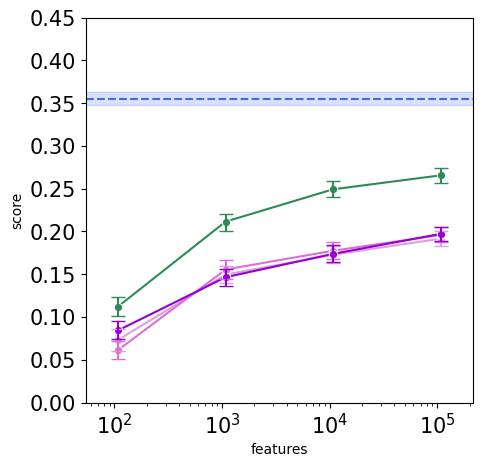

In [14]:
# main results
rcParams['figure.figsize'] = (5,5)  

ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)

# Adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])

# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='royalblue', linestyle='--', label='AlexNet')
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='royalblue', alpha=0.2)


# plt.xlabel('Number of Features',size=20)
# plt.ylabel('Encoding Score',size=20)
plt.xlim(df['features'].min()/2,df['features'].max()*2)
plt.ylim(0,0.45)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
    
plt.legend(frameon=False,fontsize=12)
#ax1.legend(fontsize=10,loc='upper left')
ax1.legend_.remove()

plt.savefig(f'random_model_{DATASET}_{region}.png', dpi=200) 
plt.show()

# PCA results

In [21]:
import math

In [29]:
def get_pc_bootstrap_data(models, num_features, num_components, layers, dataset, region, all_sampled_indices, file_name, batch_size=50, n_bootstraps=1000):


    if dataset == 'naturalscenes':
        SUBJECTS = [i for i in range(8)]
    elif dataset == 'majajhong':
        SUBJECTS = ['Chabo','Tito']
    else:
        print('unknown dataset')
    
    
    data_dict = {'model':[],'pcs':[],'score':[], 'lower':[],'upper':[]}
    mean_scores = []
    lower_bound = []
    upper_bound = []              
        
    
    for features in num_features:
        
        for n_components in num_components:

            for model_name in models:
    
                    print(model_name)
    
                    activations_identifier = load_iden(model_name=model_name, features=features, layers=layers, dataset=dataset)
                    activations_identifier = activations_identifier + f'_principal_components={n_components}'
                    print(activations_identifier)
    
                    score_sum = np.zeros(n_bootstraps)
                    #bootstrap_dist = []
    
                    for subject in tqdm(SUBJECTS):
    
                            # load preds and y_true
                            r_values = []
                            with open(os.path.join(PREDS_PATH,f'{activations_identifier}_{region}_{subject}.pkl'), 'rb') as file:
                                preds = torch.Tensor(pickle.load(file))
    
                            if dataset == 'naturalscenes':
                                ids_test, neural_data_test, var_name_test = load_nsd_data(mode ='shared', subject = subject, region = region)           
                                test = torch.Tensor(neural_data_test[var_name_test].values)
    
                            else:
                                test = load_majaj_data(subject, region, 'test')
                                
                            
                            # Vectorized bootstrapping
                            all_sampled_preds = preds[all_sampled_indices]
                            all_sampled_tests = test[all_sampled_indices]
    
                            i = 0
                            batch = batch_size
                            while i < n_bootstraps:
                                # Compute Pearson r for all bootstraps at once
                                mean_r_values = pearson_r_(all_sampled_tests[i:i+batch,:,:].cuda(), 
                                                           all_sampled_preds[i:i+batch,:,:].cuda())
                                r_values.extend(mean_r_values.tolist())
                                i += batch
    
                            score_sum += r_values
                            #bootstrap_dist.extend(r_values)


                
                    bootstrap_dist = score_sum/len(SUBJECTS)
    
                    data_dict['model'].append(f'{model_name}_{features}')
                    data_dict['pcs'].append(str(n_components))
                    data_dict['score'].append(np.mean(bootstrap_dist))
                    data_dict['lower'].append(np.percentile(bootstrap_dist, 2.5))
                    data_dict['upper'].append(np.percentile(bootstrap_dist, 97.5))
    
    
    df = pd.DataFrame.from_dict(data_dict)
    
    with open(f'bootstrap-results-{file_name}-{dataset}-{region}-df.pkl', 'wb') as file:
        pickle.dump(df,file)
        
    return df

In [30]:
DATASET = 'naturalscenes'
REGIONS = ['ventral visual stream']

# DATASET = 'majajhong'
# REGIONS = ['IT']


n_bootstraps = 1000
n_rows = 872 if DATASET=='naturalscenes' else 640
all_sampled_indices = np.random.choice(n_rows, (n_bootstraps, n_rows), replace=True) # Sample indices for all bootstraps at once


for region in REGIONS:
    
    df_pcs = get_pc_bootstrap_data(models= ['expansion'],
                            num_features=[3000],
                            num_components=[1,10,100,1000,10000],
                            dataset=DATASET, 
                            layers = 5,
                            file_name = 'expansion_pcs',
                            region=region,
                            n_bootstraps = n_bootstraps,
                            all_sampled_indices=all_sampled_indices)

expansion
expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=1


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


expansion
expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=10


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


expansion
expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=100


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.92s/it]


expansion
expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=1000


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.92s/it]


expansion
expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=10000


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.93s/it]


### perofrmance

In [24]:
DATASET = 'majajhong'
region = 'IT'
features = '30000'

DATASET = 'naturalscenes'
region = 'ventral visual stream'
features = '3000'

In [34]:
path = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data'
#load data
with open(os.path.join(path,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-expansion_pcs-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_pca = pickle.load(file) 

In [35]:
df_engineered = df_engineered[(df_engineered.model == 'expansion') & (df_engineered.features == features)].reset_index(drop=True)

df_pca['pcs'] = df_pca['pcs'].apply(lambda x: int(x))
#df_pca['fraction'] = df_pca['pcs'].apply(lambda x: math.log(x,10)/6)

names ={f'expansion_{features}':'Reduced Model'}

df_pca['model'] = df_pca['model'].map(names)
df_pca = df_pca.dropna().reset_index(drop=True)

In [36]:
palette ={'Reduced Model':'mediumseagreen'}
df_pca['color'] = df_pca['model'].map(palette)

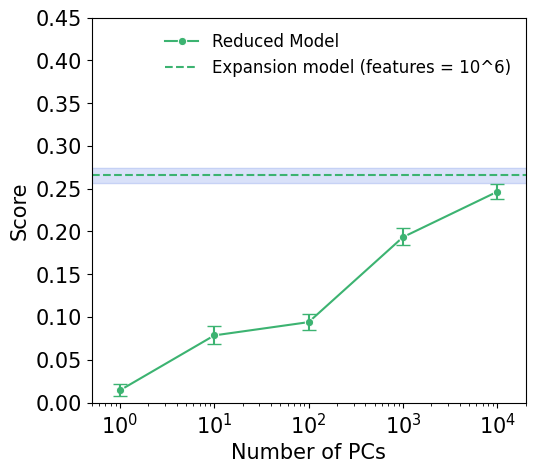

In [38]:

# main results
rcParams['figure.figsize'] = (5.6,5)  

ax1 = sns.lineplot(data = df_pca, x='pcs', y='score', hue='model', marker='o',palette = palette)
# Adding error bars for the 95% confidence interval
for i in range(len(df_pca)):
    plt.errorbar(df_pca['pcs'][i], df_pca['score'][i], 
                 yerr=[[df_pca['score'][i] - df_pca['lower'][i]], 
                       [df_pca['upper'][i] - df_pca['score'][i]]], 
                 fmt='none', capsize=5, color=df_pca['color'][i])



plt.axhline(y=df_engineered['score'][0], color='mediumseagreen', linestyle='--', label='Expansion model (features = 10^6)')
plt.fill_between(np.arange(df_pca['pcs'].min()/3,df_pca['pcs'].max()*3), 
                 df_engineered['lower'], df_engineered['upper'], color='royalblue', alpha=0.2)


plt.xlabel("Number of PCs",size=15)
plt.ylabel('Score',size=15)
plt.xlim(df_pca['pcs'].min()/2,df_pca['pcs'].max()*2)
#plt.xlim(1,0.6)

plt.ylim(0,0.45)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
    
plt.legend(frameon=False,fontsize=12)
#ax1.legend(fontsize=10,loc='upper left')
#ax1.legend_.remove()

plt.savefig(f'principal_components_{DATASET}_{region}.png', dpi=200) 
plt.show()

### % performance

In [92]:
DATASET = 'majajhong'
region = 'IT'
features = '30000'

# DATASET = 'naturalscenes'
# region = 'ventral visual stream'
# features = '3000'

In [93]:
path = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data'
#load data
with open(os.path.join(path,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-expansion_pcs-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_pca = pickle.load(file) 

In [94]:
df_engineered = df_engineered[(df_engineered.model == 'expansion') & (df_engineered.features == features)].reset_index(drop=True)
df_pca['% performance'] = df_pca['score']/df_engineered['score'][0]

df_pca['pcs'] = df_pca['pcs'].apply(lambda x: int(x))
#df_pca['fraction'] = df_pca['pcs'].apply(lambda x: math.log(x,10)/6)

names ={#'expansion_30':'Expansion (features=10^3)',
       f'expansion_{features}':'Expansion (features=10^6)'}

df_pca['model'] = df_pca['model'].map(names)

In [95]:
palette ={'Expansion (features=10^3)':'mediumseagreen','Expansion (features=10^6)':'mediumseagreen'}
df_pca['color'] = df_pca['model'].map(palette)

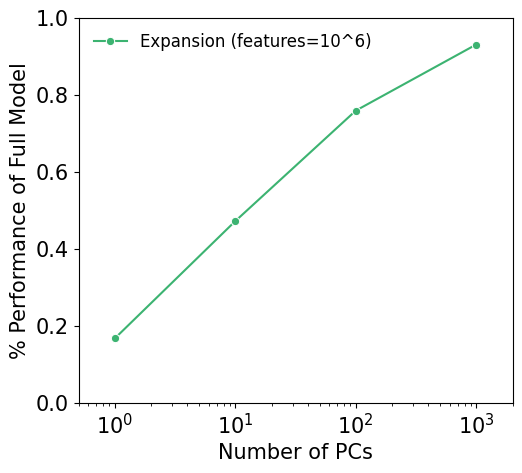

In [96]:
# main results
rcParams['figure.figsize'] = (5.6,5)  

ax1 = sns.lineplot(data = df_pca, x='pcs', y='% performance', hue='model', marker='o',palette = palette)
# Adding error bars for the 95% confidence interval
# for i in range(len(df_pca)):
#     plt.errorbar(df_pca['pcs'][i], df_pca['score'][i], 
#                  yerr=[[df_pca['score'][i] - df_pca['lower'][i]], 
#                        [df_pca['upper'][i] - df_pca['score'][i]]], 
                 # fmt='none', capsize=5, color=df_pca['color'][i])


plt.xlabel("Number of PCs",size=15)
plt.ylabel('% Performance of Full Model',size=15)
plt.xlim(df_pca['pcs'].min()/2,df_pca['pcs'].max()*2)
#plt.xlim(1,0.6)

plt.ylim(0,1)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
    
plt.legend(frameon=False,fontsize=12)
#ax1.legend(fontsize=10,loc='upper left')
#ax1.legend_.remove()

plt.savefig(f'principal_components_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Image pixel shuffle

In [102]:
# DATASET = 'naturalscenes'
# REGIONS = ['midventral visual stream','early visual stream','ventral visual stream']

DATASET = 'majajhong_shuffled'
REGIONS = ['V4','IT']


n_bootstraps = 1000  
n_rows = 872 if DATASET=='naturalscenes' else 640
all_sampled_indices = np.random.choice(n_rows, (n_bootstraps, n_rows), replace=True) # Sample indices for all bootstraps at once


for region in REGIONS:
    
    
    df_engineered_shuffled = get_bootstrap_data(models= ['expansion'],
                            num_features=[3,30,300,3000,30000],
                            dataset=DATASET, 
                            layers = 5,
                            file_name = 'expansion',
                            region=region,
                            n_bootstraps = n_bootstraps,
                            all_sampled_indices=all_sampled_indices)
    

3
expansion
expansion_features=3_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


30
expansion
expansion_features=30_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.21it/s]


300
expansion
expansion_features=300_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.33it/s]


3000
expansion
expansion_features=3000_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


30000
expansion
expansion_features=30000_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.21it/s]


3
expansion
expansion_features=3_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.17it/s]


30
expansion
expansion_features=30_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


300
expansion
expansion_features=300_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.48it/s]


3000
expansion
expansion_features=3000_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.46it/s]


30000
expansion
expansion_features=30000_layers=5_dataset=majajhong_shuffled


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.34it/s]


In [156]:
region = 'IT'
DATASET = 'majajhong'

In [34]:
path = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data'

with open(os.path.join(path,f'bootstrap-results-expansion-{DATASET}_shuffled-{region}-df.pkl'), 'rb') as file:
    df_engineered_shuffled = pickle.load(file)
    
with open(os.path.join(path,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)

with open(os.path.join(path,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [35]:
# df = new_data.copy()
df_engineered['features'] = df_engineered['features'].apply(lambda x: int(x)*36)
df_engineered_shuffled['features'] = df_engineered_shuffled['features'].apply(lambda x: int(x)*36)

df_engineered['dataset'] = 'Normal images'
df_engineered_shuffled['dataset'] = 'Shuffled pixels'


In [36]:
df = pd.concat([df_engineered,df_engineered_shuffled])

In [37]:
# df = new_data.copy()
names ={'expansion':'Expansion'}
df['model'] = df['model'].map(names)

palette ={'Normal images':'seagreen','Shuffled pixels':'gray'}
df['color'] = df['dataset'].map(palette)
df = df.dropna().reset_index()

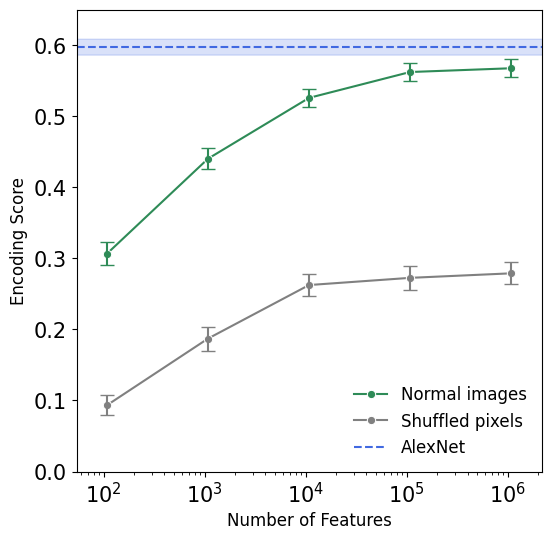

In [38]:
# main results
rcParams['figure.figsize'] = (6,6)  

ax1 = sns.lineplot(data = df, x='features', y='score', hue='dataset', marker='o',palette = palette)
# main results
rcParams['figure.figsize'] = (6,6)  

# Adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])
    
# alexnet results
# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='royalblue', linestyle='--', label='AlexNet')
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='royalblue', alpha=0.2)


plt.xlabel('Number of Features',size=12)
plt.ylabel('Encoding Score',size=12)
plt.ylim(0,0.65)
plt.xlim(df['features'].min()/2,df['features'].max()*2)

plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
    
#plt.legend()
ax1.legend(frameon=False,fontsize=12)
#ax1.legend_.remove()

plt.savefig(f'shuffled_pixels_{DATASET}_{region}.png', dpi=200) 
plt.show()